In [1]:
from Models import MultiLayerNN, OneLayerNN
import torchinfo, torch, Data
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from IPython.display import display, clear_output
import time
from Utility import getFourierCoeffs

# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
device = torch.device("cpu")

print("Using device", device)

Using device cpu


In [2]:
def true_func(x):
    return np.sin(np.pi*x)

def func1(x):
    noise = 0.2*np.sin(4*np.pi*x) + 0.15*np.sin(7*np.pi*x)
    return true_func(x) + noise

def add_noise_func(x, p):
    vals = true_func(x)
    for i in range(len(vals)):
        if np.random.random() <= p:
            vals[i] = vals[i] + np.random.normal(loc=0, scale=0.25)
    return vals

np.random.seed(33)
SAMPLE_SIZE = 1200
x_train = np.linspace(-1,1,SAMPLE_SIZE)
y_train = func1(x_train)
xy_ds = Data.FuncData(x_train, y_train)
xy_dl = torch.utils.data.DataLoader(xy_ds, batch_size=100, shuffle=True)

BENCHMARK MSE = 0.03122395833333334


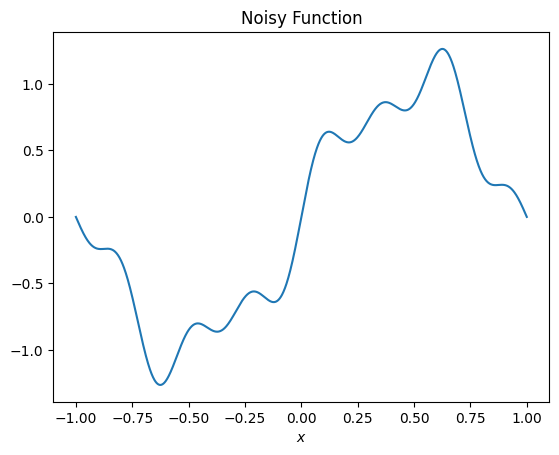

In [3]:
plt.plot(x_train, y_train)
plt.title("Noisy Function")
plt.xlabel("$x$")

# Compute benchmark error
BENCHMARK_MSE = np.mean(np.square(y_train - true_func(x_train)))
print("BENCHMARK MSE =", BENCHMARK_MSE)

In [10]:
def compute_NN_function(num_epochs, hidden_units, xy_dl):
    def getFourierCoeffs(x, func, num=11):
        num_pts = len(x)
        sin_coeffs = []
        cos_coeffs = []
        for i in range(1,num+1):
            sin_coeffs.append(sum(func(x) * np.sin(i*np.pi*x)) * ((np.max(x)-np.min(x))/num_pts))
            cos_coeffs.append(sum(func(x) * np.cos(i*np.pi*x)) * ((np.max(x)-np.min(x))/num_pts))
        zero_cos_coeff = sum(func(x)) * ((np.max(x)-np.min(x))/num_pts)
        return (sin_coeffs, [zero_cos_coeff] + cos_coeffs)

    LEARNING_RATE = 0.05
    np.random.seed(1113)
    torch.manual_seed(1113)
    model = OneLayerNN(hidden_size=hidden_units, activation=torch.nn.Tanh()).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss = torch.nn.MSELoss()

    sin_coeffs_mat = []
    nn_func = lambda x: model(torch.tensor(x).to(device).float().unsqueeze(-1)).cpu().detach().numpy().flatten()
    for epoch in range(num_epochs):
        sin_coeffs, _ = getFourierCoeffs(x_train, nn_func, num=12)
        sin_coeffs_mat.append(sin_coeffs)
        epoch_loss = 0
        for X,Y in xy_dl:
            _X = X.to(device)
            _Y = Y.to(device)
            Y_hat = model(_X)
            optimizer.zero_grad()
            L = loss(_Y, Y_hat)
            L.backward()
            optimizer.step()
            epoch_loss += float(L.item()) / len(xy_dl.dataset)
        print('Epoch',epoch,'| Loss:', epoch_loss, end='\r')

    return nn_func, sin_coeffs_mat

In [72]:
nn_func, sin_coeffs_mat = compute_NN_function(200, 30000, xy_dl)
# NOTE: Add in x_test and y_test later for generealization error measurements
# print("TEST MSE =", np.mean(np.square(y_test - func1(x_test))))

Something interesting here is that when `hidden_size` is set to `30000`, the NN learns the weights exactly after 200 epochs, except the sign on the frequency=3 component is wrong... Why?

1.0341633399339625 -0.24658829712995575 0.14061410043064876
(200, 12)


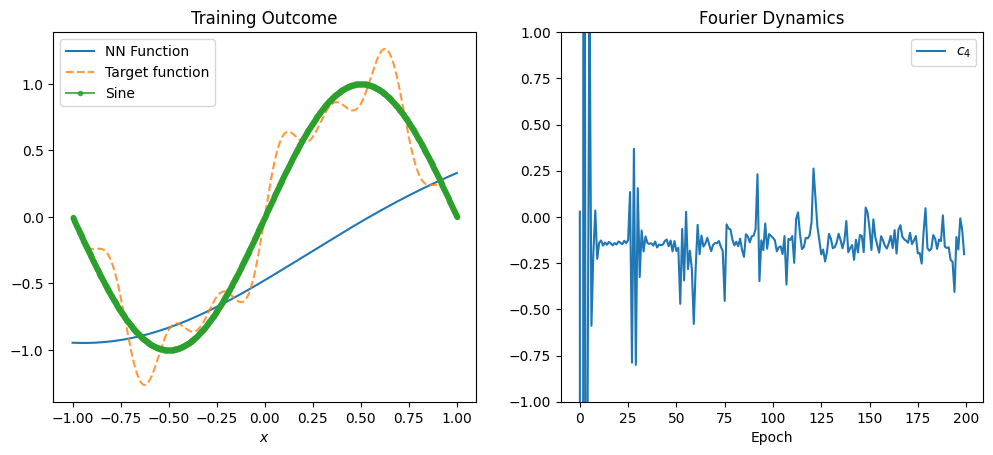

In [79]:
fig,axs = plt.subplots(1,2)
axs[0].plot(x_train, nn_func(x_train), label='NN Function')
axs[0].plot(x_train, y_train, '--', alpha=0.8, label='Target function')
axs[0].plot(x_train, np.sin(np.pi*x_train), '.-', alpha=0.8, label='Sine')
axs[0].legend()
axs[0].set_xlabel("$x$")
axs[0].title.set_text("Training Outcome")

sin_coeffs_mat = np.array(sin_coeffs_mat)
print(np.mean(sin_coeffs_mat[:,0]), np.mean(sin_coeffs_mat[:,3]), np.mean(sin_coeffs_mat[:,6]))
print(sin_coeffs_mat.shape)
for i in range(sin_coeffs_mat.shape[1]):
    if i==1-1 or i==4-1 or i==7-1:
        axs[1].plot(sin_coeffs_mat[:,i], label=f"$c_{i+1}$")
axs[1].legend()
axs[1].title.set_text("Fourier Dynamics")
axs[1].set_xlabel("Epoch")
axs[1].set_ylim([-1,1])
fig.set_figwidth(12)

## Investigate the effect of varying width on frequency learning

In [49]:
hidden_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]
print("Carrying out trial on hidden sizes:", hidden_sizes)
test_errors = []
sin_coeffs_mats = []
NUM_EPOCHS = 350
for i in tqdm(range(len(hidden_sizes))):
    s = hidden_sizes[i]
    nn_func, sin_coeffs_mat = compute_NN_function(NUM_EPOCHS, s, xy_dl)
    test_error = np.mean(np.square(nn_func(x_train) - y_train))
    test_errors.append(test_error)
    sin_coeffs_mats.append(sin_coeffs_mat)

Carrying out trial on hidden sizes: [16, 32, 64, 128, 256, 512, 1024, 2048]


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:12<01:29, 12.79s/it]

 25%|██▌       | 2/8 [00:25<01:16, 12.68s/it]

 38%|███▊      | 3/8 [00:38<01:04, 12.81s/it]

 50%|█████     | 4/8 [00:52<00:52, 13.16s/it]

 62%|██████▎   | 5/8 [01:06<00:40, 13.65s/it]

 75%|███████▌  | 6/8 [01:23<00:29, 14.79s/it]

 88%|████████▊ | 7/8 [01:49<00:18, 18.38s/it]

100%|██████████| 8/8 [02:59<00:00, 34.74s/it]

100%|██████████| 8/8 [02:59<00:00, 22.39s/it]


(8, 350, 12)


Text(0.1, 1.02, 'No. Epochs=350')

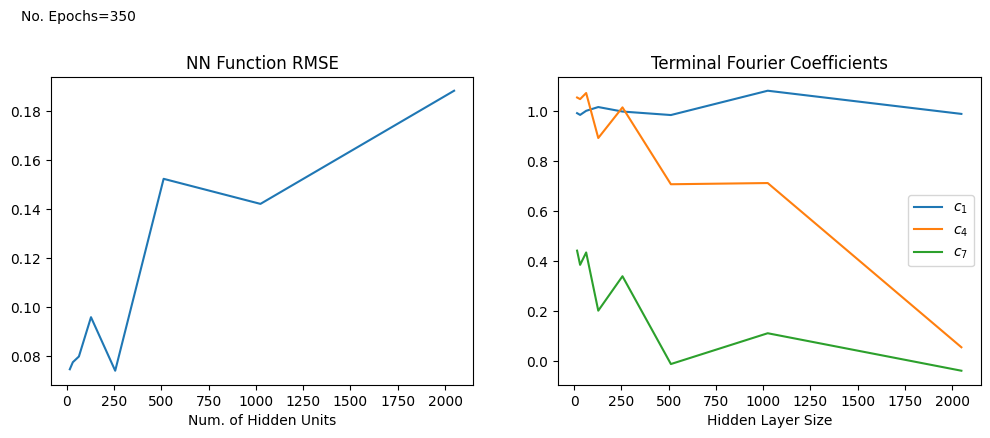

In [68]:
fig, axs = plt.subplots(1,2)
axs[0].plot(hidden_sizes, np.sqrt(test_errors))
axs[0].set_xlabel("Num. of Hidden Units")
axs[0].title.set_text("NN Function RMSE")

sin_coeffs_mats = np.array(sin_coeffs_mats)
m,n,d = sin_coeffs_mats.shape
print(sin_coeffs_mats.shape)
terminal_coeffs = np.zeros((sin_coeffs_mats.shape[0], 3))
for i in range(m):
    c1_i = sin_coeffs_mats[i,-1,0]
    c4_i = sin_coeffs_mats[i,-1,3]
    c7_i = sin_coeffs_mats[i,-1,6]
    terminal_coeffs[i,:] = np.array([c1_i, c4_i, c7_i])
mm,nn = terminal_coeffs.shape
labels = ["$c_1$", "$c_4$", "$c_7$"]
target_coeffs = [1, 0.2, 0.15]
for i in range(nn):
    axs[1].plot(hidden_sizes, terminal_coeffs[:,i] / target_coeffs[i], label=labels[i])
axs[1].set_xlabel("Hidden Layer Size")
axs[1].title.set_text("Terminal Fourier Coefficients")
axs[1].legend()
fig.set_figwidth(12)
fig.set_figheight(4)
plt.figtext(0.1, 1.02, f"No. Epochs={NUM_EPOCHS}")